In [152]:
'''
Testing the initial part of HOSSEINsolver with an IDC solver
'''

import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

def func(t, y):
    return 4*t*(y)**(0.5)

def y_exact(t):
    return (1 + t**2)**2

def func2d(t, y):
    y1 = y[0]
    y2 = y[1]
    y1_p = -y2 + y1*(1-y1**2-y2**2)
    y2_p = y1 + 3*y2*(1-y1**2-y2**2)
    return np.array([y1_p, y2_p])


F = lambda t,y : 4*t*y**(0.5)
G = lambda t,y : y
G_sol = lambda t : np.exp(t)
F_sol = lambda t : (1+t**2)**2


def beta(M):
    '''
    Generates beta coefficients for Adam-Bashforth integrating scheme
    These coefficients are stored in reversed compared to conventional
    Adam-Bashforth implementations (the first element of beta corresponds to
    earlier point in time).
    input:
    M: the order of Adam-Bashforth scheme
    '''
    if M == 2:
        return np.array([-1./2, 3./2])
    elif M == 3:
        return np.array([5./12, -16./12, 23./12])
    elif M == 4:
        return np.array([-9./24, 37./24, -59./24, 55./24])
    elif M == 5:
        return np.array([251./720, -1274./720, 2616./720, -2774./720, 1901./720])
    elif M == 6:
        return np.array([-475./720, 2877./720, -7298./720, 9982./720, -7923./720, 4277./720])


In [335]:
#feedback

def HOSSEINsolver2(func, T, y0, N, M):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop

    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    d = len(y0)
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros([N+1,d])
    # putting the initial condition in y
    yy[0,:] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M,d])
    F1[:, 0,:] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones([M,d])*y0
    
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 4
    for iTime in range(0, M-1):
        KK1 = F1[0, iTime,:]
        KK2 = func(t[iTime]+h/2, Y2[0,:]+KK1*h/2)
        KK3 = func(t[iTime]+h/2, Y2[0,:]+KK2*h/2)
        KK4 = func(t[iTime]+h,   Y2[0,:]+KK3*h)
        Y2[0,:] = Y2[0,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
        # Y2[0] = Y2[0] + h*KK1
        F1[0, iTime+1,:] = func(t[iTime+1], Y2[0,:])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, iTime,:]-F1[ll, iTime,:]) + \
                h * np.dot(S[iTime, :], F1[ll, :,:])
            F1[iCor, iTime+1,:] = func(t[iTime+1], Y2[iCor,:])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1,:] = Y2[M-1,:] + h*(F2-F1[M-2, iTime,:]) + \
            h * np.dot(S[iTime, :], F1[M-2, :,:])
        F2 = func(t[iTime+1], Y2[M-1,:])
        yy[iTime+1,:] = Y2[M-1,:]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(M)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, -1,:]-F1[ll, -2,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        F1[0, 0:M-1,:] = F1[0, 1:M,:]
        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0:M-1,:] = F1[iCor, 1:M,:]
            F1[iCor, M-1,:] = func(t_ext[iTime+1-iCor], Y2[iCor,:])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, -1,:]-F1[ll, -2,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        # last correction loop
        Y2[M-1,:] = Y2[M-1,:] + h * (F2-F1[M-2, -2,:]) + \
            h * np.dot(Svec, F1[M-2, :,:])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0:M-1,:] = F1[ll, 1:M,:]
            F1[ll, M-1,:] = func(t_ext[iTime+1-ll], Y2[ll,:])
        # storing the final answer
        yy[iTime+1-(M-1),:] = Y2[M-1,:]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1,:])
        # ---> updating predictor stencil
        # ** approach #0:
        #F1[0, 0:M-1,:] = F1[0, 1:M,:]
        # ** approach #1: pushing the most correct answer to predictor
        # F1[0, 0] = F2
        # F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        F1[0, 0,:] = F2
        for ii in range(1, M-1):
             F1[0, ii,:] = F1[-ii, -1,:]

        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])

    return t, yy

In [336]:
#no feedback

def HOSSEINsolver0(func, T, y0, N, M):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop

    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    d = len(y0)
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros([N+1,d])
    # putting the initial condition in y
    yy[0,:] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M,d])
    F1[:, 0,:] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones([M,d])*y0
    
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 4
    for iTime in range(0, M-1):
        KK1 = F1[0, iTime,:]
        KK2 = func(t[iTime]+h/2, Y2[0,:]+KK1*h/2)
        KK3 = func(t[iTime]+h/2, Y2[0,:]+KK2*h/2)
        KK4 = func(t[iTime]+h,   Y2[0,:]+KK3*h)
        Y2[0,:] = Y2[0,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
        # Y2[0] = Y2[0] + h*KK1
        F1[0, iTime+1,:] = func(t[iTime+1], Y2[0,:])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, iTime,:]-F1[ll, iTime,:]) + \
                h * np.dot(S[iTime, :], F1[ll, :,:])
            F1[iCor, iTime+1,:] = func(t[iTime+1], Y2[iCor,:])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1,:] = Y2[M-1,:] + h*(F2-F1[M-2, iTime,:]) + \
            h * np.dot(S[iTime, :], F1[M-2, :,:])
        F2 = func(t[iTime+1], Y2[M-1,:])
        yy[iTime+1,:] = Y2[M-1,:]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(M)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, -1,:]-F1[ll, -2,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        F1[0, 0:M-1,:] = F1[0, 1:M,:]
        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0:M-1,:] = F1[iCor, 1:M,:]
            F1[iCor, M-1,:] = func(t_ext[iTime+1-iCor], Y2[iCor,:])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, -1,:]-F1[ll, -2,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        # last correction loop
        Y2[M-1,:] = Y2[M-1,:] + h * (F2-F1[M-2, -2,:]) + \
            h * np.dot(Svec, F1[M-2, :,:])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0:M-1,:] = F1[ll, 1:M,:]
            F1[ll, M-1,:] = func(t_ext[iTime+1-ll], Y2[ll,:])
        # storing the final answer
        yy[iTime+1-(M-1),:] = Y2[M-1,:]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1,:])
        # ---> updating predictor stencil
        # ** approach #0:
        F1[0, 0:M-1,:] = F1[0, 1:M,:]
        # ** approach #1: pushing the most correct answer to predictor
        # F1[0, 0] = F2
        # F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        # F1[0, 0] = F2
        # for ii in range(1, M-1):
        #     F1[0, ii] = F1[-ii, -1]

        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])

    return t, yy

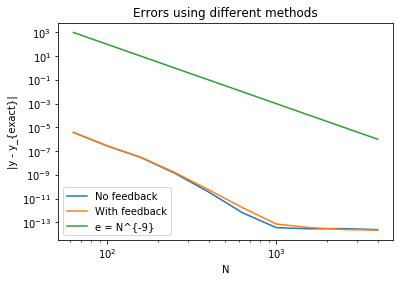

In [339]:
T1 = 96
M = 5
Mm = M - 1
y0 = np.array([1])
# Y_exact = (1 + np.linspace(0, T1, N)**2)**2
yExact = (1 + T1**2)**2
rangeN = [int(10**n) for n in np.arange(1.8, 3.8, 0.2)]
rangeNpower = [(10**12)*int(10**n)**(-5) for n in np.arange(1.8, 3.8, 0.2)]


err0 = np.empty(np.shape(rangeN))
err2 = np.empty(np.shape(rangeN))
err3 = np.empty(np.shape(rangeN))
for i, NN in enumerate(rangeN):
    t_0, yy_0 = HOSSEINsolver0(func, T1, y0, NN-1, M)
    t_2, yy_2 = HOSSEINsolver2(func, T1, y0, NN-1, M)

    err0[i] = abs((yExact-yy_0[-1])/yExact)
    err2[i] = abs((yExact-yy_2[-1])/yExact)



fig, ax = plt.subplots()
ax.plot(rangeN, err0, label='No feedback')
ax.plot(rangeN, err2, label='With feedback')

ax.plot(rangeN, rangeNpower, label='e = N^{-9}')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')  # Add an x-label to the axes.
ax.set_ylabel('|y - y_{exact}|')
ax.set_title("Errors using different methods")
ax.legend(loc='lower left')
plt.show()
# print(Y_exact[-1])
# print(yy_0[-1], abs(Y_exact[-1]-yy_0[-1]))
# print(yy_2[-1], abs(Y_exact[-1]-yy_2[-1]))
# print('error ratio', abs(Y_exact[-1]-yy_2[-1])/abs(Y_exact[-1]-yy_0[-1]))


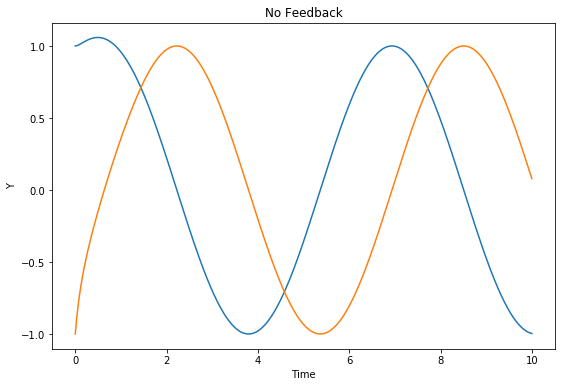

In [8]:

T = np.linspace(0,10,1001)




fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(T,K[1][:,0] , label='No feedback')
ax.plot(T,K[1][:,1], label='No feedback')
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('No Feedback')
plt.show()

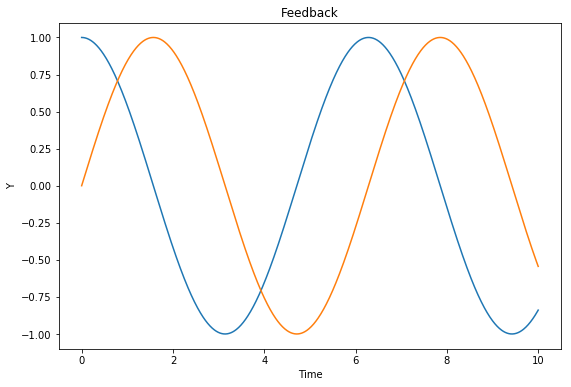

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(T,K1[1][:,0] , label='No feedback')
ax.plot(T,K1[1][:,1], label='No feedback')
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('Feedback')
plt.show()

In [340]:
errorlist2 = []
stepsizelist2 = []

for i in [10,200]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolver2(func, 2, np.array([1.0]), i, 4)
    stepsizelist2.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist2.append(max(m))
    
errorlist3 = []
stepsizelist3 = []

for i in [10,200]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolver2(func, 2, np.array([1.0]), i, 5)
    stepsizelist3.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist3.append(max(m))

errorlist4 = []
stepsizelist4 = []

for i in [10,200]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolver2(func, 2, np.array([1.0]), i, 2)
    stepsizelist4.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist4.append(max(m))


    


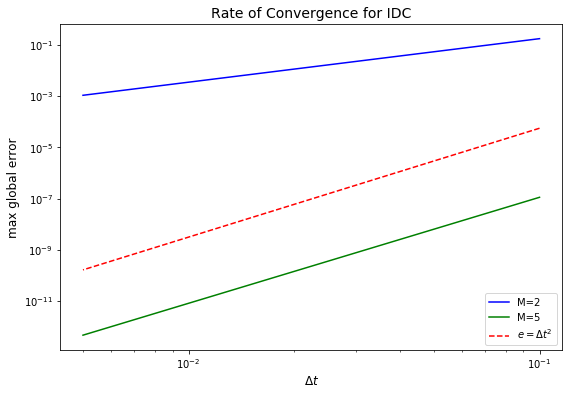

In [341]:
test1 = [i**4.25 for i in stepsizelist2]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
#plt.plot(stepsizelist2, errorlist2, 'r-', markersize=2, label = 'M=4')
plt.plot(stepsizelist4, errorlist4, 'b-', markersize=2, label = 'M=2')
plt.plot(stepsizelist3, errorlist3, 'g-', markersize=2, label = 'M=5')
plt.plot(stepsizelist2, test1,'r--',markersize=2,label = '$e = \Delta t^{2}$ ' )
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for IDC',fontsize = 14)

plt.show()

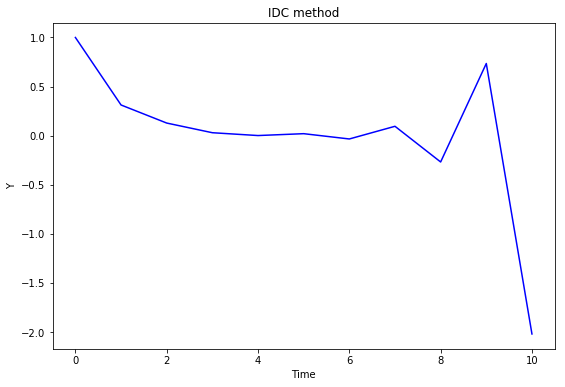

array([[ 1.00000000e+00],
       [ 3.12246124e-01],
       [ 1.28269280e-01],
       [ 2.98373506e-02],
       [ 1.02837614e-03],
       [ 2.00557636e-02],
       [-3.38186162e-02],
       [ 9.52892236e-02],
       [-2.68163668e-01],
       [ 7.34912767e-01],
       [-2.01997287e+00]])

In [231]:
(func, 2, np.array([1.0]), i, 2)
G = lambda t,y : -1.1*y
T1 = np.linspace(0,10,11)
K2 = HOSSEINsolver0(G,10,np.array([1.0]),10,4)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(T1, K2[1], 'b-', markersize=2)
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('IDC method')
plt.show()
K2[1]

## Testing different stencils

In [163]:
errorlist2 = []
stepsizelist2 = []

for i in [10,2000]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolver0(func, 2, np.array([1.0]), i, 4)
    stepsizelist2.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist2.append(max(m))

In [164]:
errorlist3 = []
stepsizelist3 = []

for i in [10,2000]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolver2(func, 2, np.array([1.0]), i, 4)
    stepsizelist3.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist3.append(max(m)[0])
errorlist3

[8.064585585998429e-07, 2.842170943040401e-14]

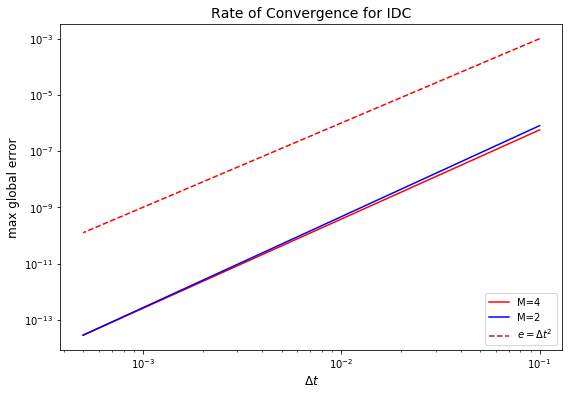

In [165]:
test1 = [i**3 for i in stepsizelist2]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(stepsizelist2, errorlist2, 'r-', markersize=2, label = 'M=4')
plt.plot(stepsizelist3, errorlist3, 'b-', markersize=2, label = 'M=2')
plt.plot(stepsizelist2, test1,'r--',markersize=2,label = '$e = \Delta t^{2}$ ' )
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for IDC',fontsize = 14)

plt.show()

## AB4 correctors
### my attempt

In [12]:
def Ab4(F,T,y0,N):
    betavec = beta(4)
    h = float(T)/N
    ts = np.linspace(0,T,N+1)
    d = len(y0)
    Y = np.zeros((N+1,d))
    Y[0,:] = y0
    
    for t in range(3):
        KK1 = F(ts[t],Y[t,:])
        KK2 = F(ts[t]+h/2, Y[t,:]+KK1*h/2)
        KK3 = F(ts[t]+h/2, Y[t,:]+KK2*h/2)
        KK4 = F(ts[t]+h,Y[t,:]+KK3*h)
        Y[t+1,:] = Y[t,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
    for t in range(3,N):
        L = np.array([F(ts[t-3],Y[t-3,:]),F(ts[t-2],Y[t-2,:]),F(ts[t-1],Y[t-1,:]),F(ts[t],Y[t,:])])
        Y[t+1,:] = Y[t,:] +h*np.dot(betavec,L)
        
    return Y
        

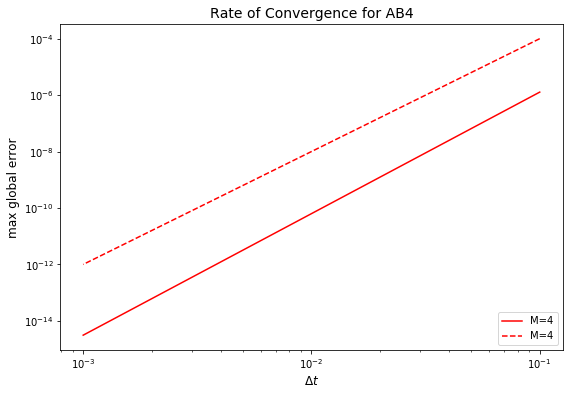

In [124]:
errorlist2 = []
stepsizelist2 = []

for i in [10,1000]:   
    T = np.linspace(0, 1, i+1)
    K2 = Ab4(F,1,np.array([1.0]),i)
    stepsizelist2.append(1/(i))
    m = [abs(K2[j] - F_sol(T[j])) for j in range(i)]
    errorlist2.append(max(m))
    
test1 = [i**4 for i in stepsizelist2]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(stepsizelist2, errorlist2, 'r-', markersize=2, label = 'M=4')
plt.plot(stepsizelist2, test1, 'r--', markersize=2, label = 'M=4')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for AB4',fontsize = 14)

plt.show()

In [27]:
def HOSSEINsolverAB1(func, T, y0, N, M):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop

    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    d = len(y0)
    beta_vec1 = beta(2)
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros([N+1,d])
    # putting the initial condition in y
    yy[0,:] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M x d]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([M, M,d])
    F1[:, 0,:] = F0
    F2 = F0
    # Y2 [M x d] new point derived in each level (prediction and corrections)
    Y2 = np.ones([M,d])*y0
    
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 4
    for iTime in range(0, M-1):
        KK1 = F1[0, iTime,:]
        KK2 = func(t[iTime]+h/2, Y2[0,:]+KK1*h/2)
        KK3 = func(t[iTime]+h/2, Y2[0,:]+KK2*h/2)
        KK4 = func(t[iTime]+h,   Y2[0,:]+KK3*h)
        Y2[0,:] = Y2[0,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
        # Y2[0] = Y2[0] + h*KK1
        F1[0, iTime+1,:] = func(t[iTime+1], Y2[0,:])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            KK1 = func(t[iTime], Y2[iCor,:]) - func(t[iTime], Y2[ll,:])
            KK2 = func(t[iTime]+h/2, Y2[iCor,:]+KK1*h/2) - func(t[iTime]+h/2, Y2[ll,:]+KK1*h/2)
            KK3 = func(t[iTime]+h/2, Y2[iCor,:]+KK2*h/2) - func(t[iTime]+h/2, Y2[ll,:]+KK2*h/2)
            KK4 = func(t[iTime]+h,Y2[iCor,:]+KK3*h) - func(t[iTime]+h,Y2[ll,:]+KK3*h)
            Y2[iCor,:] = Y2[iCor,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6 + h * np.dot(S[iTime, :], F1[ll, :,:])
            
            F1[iCor, iTime+1,:] = func(t[iTime+1], Y2[iCor,:])
            
            
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        
        KK1 = func(t[iTime], Y2[M-1,:]) - func(t[iTime], Y2[M-2,:])
        KK2 = func(t[iTime]+h/2, Y2[M-1,:]+KK1*h/2) - func(t[iTime]+h/2, Y2[M-2,:]+KK1*h/2)
        KK3 = func(t[iTime]+h/2, Y2[M-1,:]+KK2*h/2) - func(t[iTime]+h/2, Y2[M-2,:]+KK2*h/2)
        KK4 = func(t[iTime]+h,Y2[M-1,:]+KK3*h) - func(t[iTime]+h,Y2[M-2,:]+KK3*h)
        Y2[M-1,:] = Y2[M-1,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6 + h * np.dot(S[iTime, :], F1[M-2, :,:])
        
        
        F1[M-1, iTime+1,:] = func(t[iTime+1], Y2[M-1,:])
        F2 = func(t[iTime+1], Y2[M-1,:])
        yy[iTime+1,:] = Y2[M-1,:]
        print(Y2[M-1,:])
    # ================== INITIAL PART (2) ==================
    beta_vec = beta(M)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*np.dot(beta_vec,F1[iCor, :,:]-F1[ll, :,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        F1[0, 0:M-1,:] = F1[0, 1:M,:]
        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0:M-1,:] = F1[iCor, 1:M,:]
            F1[iCor, M-1,:] = func(t_ext[iTime+1-iCor], Y2[iCor,:])
    
    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*np.dot(beta_vec,F1[iCor, :,:]-F1[ll, :,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        # last correction loop
        Y2[M-1,:] = Y2[M-1,:] + h * np.dot(beta_vec,F1[M-1,:,:]-F1[M-2,:,:]) + h* np.dot(Svec, F1[M-2, :,:])
        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M):
            F1[ll, 0:M-1,:] = F1[ll, 1:M,:]
            F1[ll, M-1,:] = func(t_ext[iTime+1-ll], Y2[ll,:])
        # storing the final answer
        yy[iTime+1-(M-1),:] = Y2[M-1,:]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1,:])
        # ---> updating predictor stencil
        # ** approach #0:
        #F1[0, 0:M-1,:] = F1[0, 1:M,:]
        # ** approach #1: pushing the most correct answer to predictor
        F1[0, 0] = F2
        F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        #F1[0, 0,:] = F2
        #for ii in range(1, M-1):
             #F1[0, ii,:] = F1[-ii, -1,:]

        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])

    return t, yy

[1.00004999]
[1.00019997]
[1.00044998]


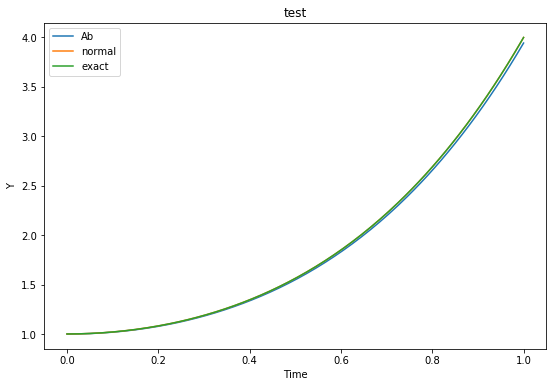

In [28]:
M = HOSSEINsolverAB1(func, 1, np.array([1.0]), 200, 4)
M1 = HOSSEINsolver0(func, 1, np.array([1.0]), 200, 4)
T = np.linspace(0, 1, 201)


fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(T,M[1] , label='Ab')
ax.plot(T,M1[1] , label='normal')
ax.plot(T,y_exact(T), label='exact')
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('test')
plt.legend()
plt.show()



In [117]:
errorlist2 = []
stepsizelist2 = []

for i in [50,2000,10000]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolverAB1(func, 2, np.array([1.0]), i, 4)
    stepsizelist2.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist2.append(max(m)[0])
    
errorlist2

[1.00315694]
[1.0126731]
[1.02871063]
[1.000002]
[1.000008]
[1.000018]
[1.00000008]
[1.00000032]
[1.00000072]


[2.7242210152147024, 0.07551950206759983, 0.015135025050735607]

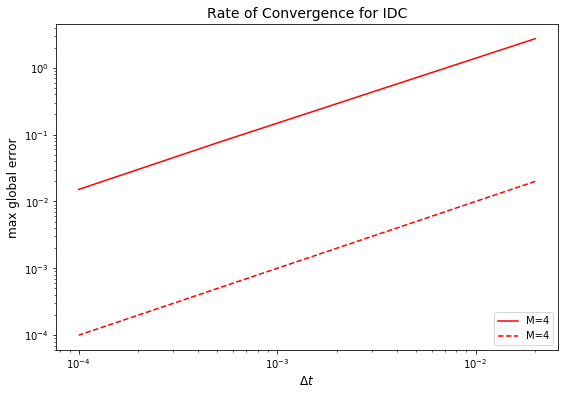

In [118]:
test1 = [i for i in stepsizelist2]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(stepsizelist2, errorlist2, 'r-', markersize=2, label = 'M=4')
plt.plot(stepsizelist2, test1, 'r--', markersize=2, label = 'M=4')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for IDC',fontsize = 14)

plt.show()

In [ ]:
# This code is no good 

### Hosseins attempt

In [263]:
def HOSSEINsolverAB(func, T, y0, N, M):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop
    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros(N+1)
    # putting the initial condition in y
    yy[0] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M])
    F1[:, 0] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones(M)*y0
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 4
    for iTime in range(0, M-1):
        KK1 = F1[0, iTime]
        KK2 = func(t[iTime]+h/2, Y2[0]+KK1*h/2)
        KK3 = func(t[iTime]+h/2, Y2[0]+KK2*h/2)
        KK4 = func(t[iTime]+h,   Y2[0]+KK3*h)
        Y2[0] = Y2[0] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
        # Y2[0] = Y2[0] + h*KK1
        F1[0, iTime+1] = func(t[iTime+1], Y2[0])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, iTime]-F1[ll, iTime]) + \
                h * np.dot(S[iTime, :], F1[ll, :])
            F1[iCor, iTime+1] = func(t[iTime+1], Y2[iCor])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1] = Y2[M-1] + h*(F2-F1[M-2, iTime]) + \
            h * np.dot(S[iTime, :], F1[M-2, :])
        F2 = func(t[iTime+1], Y2[M-1])
        yy[iTime+1] = Y2[M-1]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(M)
    beta_vec2 = beta(M-1)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, :])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
                h * np.dot(Svec, F1[ll, :])
        F1[0, 0: M-1] = F1[0, 1: M]
        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0: M-1] = F1[iCor, 1: M]
            F1[iCor, M-1] = func(t_ext[iTime+1-iCor], Y2[iCor])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, :])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            # Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
            #    h * np.dot(Svec, F1[ll, :])
            Fvec = np.array([F1[iCor, -3]-F1[ll, -4], F1[iCor, -2] -
                             F1[ll, -3], F1[iCor, -1]-F1[ll, -2]])
            Y2[iCor] = Y2[iCor] + h*np.dot(beta_vec2, Fvec) + \
                h * np.dot(Svec, F1[ll, :])
        # last correction loop
        F2m = func(t_ext[iTime+1-(M-1)-2], yy[iTime+1-(M-1)-2])
        F2mm = func(t_ext[iTime+1-(M-1)-3], yy[iTime+1-(M-1)-3])
        Fvec = np.array([F2mm-F1[M-2, -4], F2m-F1[M-2, -3], F2-F1[M-2, -2]])
        Y2[M-1] = Y2[M-1] + h*np.dot(beta_vec2, Fvec) + \
            h * np.dot(Svec, F1[M-2, :])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0: M-1] = F1[ll, 1: M]
            F1[ll, M-1] = func(t_ext[iTime+1-ll], Y2[ll])
        # storing the final answer
        yy[iTime+1-(M-1)] = Y2[M-1]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1])
        # ---> updating predictor stencil
        # ** approach #0:
        F1[0, 0: M-1] = F1[0, 1: M]
        # ** approach #1: pushing the most correct answer to predictor
        # F1[0, 0] = F2
        # F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        # F1[0, 0] = F2
        # for ii in range(1, M-1):
        #     F1[0, ii] = F1[-ii, -1]

        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])

    return t, yy




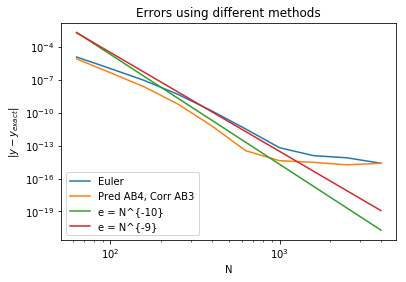

In [264]:
T1 = 96
M = 4
Mm = M - 1
y0 = np.array([1])
# Y_exact = (1 + np.linspace(0, T1, N)**2)**2
yExact = (1 + T1**2)**2
rangeN = [int(10**n) for n in np.arange(1.8, 3.8, 0.2)]
rangeNpower = [(2*10**15)*int(10**n)**(-10) for n in np.arange(1.8, 3.8, 0.2)]
rangeNpower2 = [(3*10**13)*int(10**n)**(-9) for n in np.arange(1.8, 3.8, 0.2)]

err0 = np.empty(np.shape(rangeN))
err2 = np.empty(np.shape(rangeN))
for i, NN in enumerate(rangeN):
    t_0, yy_0 = HOSSEINsolver0(func, T1, y0, NN-1, M)
    t_2, yy_2 = HOSSEINsolverAB(func, T1, y0, NN-1, M)
    err0[i] = abs((yExact-yy_0[-1])/yExact)
    err2[i] = abs((yExact-yy_2[-1])/yExact)

fig, ax = plt.subplots()
ax.plot(rangeN, err0, label='Euler')
ax.plot(rangeN, err2, label='Pred AB4, Corr AB3')
ax.plot(rangeN, rangeNpower, label='e = N^{-10}')
ax.plot(rangeN, rangeNpower2, label='e = N^{-9}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')  # Add an x-label to the axes.
ax.set_ylabel('$|y - y_{exact}|$')
ax.set_title("Errors using different methods")
ax.legend(loc='lower left')
plt.show()
# print(Y_exact[-1])
# print(yy_0[-1], abs(Y_exact[-1]-yy_0[-1]))
# print(yy_2[-1], abs(Y_exact[-1]-yy_2[-1]))
# print('error ratio', abs(Y_exact[-1]-yy_2[-1])/abs(Y_exact[-1]-yy_0[-1]))

In [210]:
errorlist3 = []
stepsizelist3 = []
l1=[]
for i in [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolverAB(func, 2, np.array([1.0]), i, 4)
    stepsizelist3.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist3.append(max(m))
    l1.append((i,max(m)))
    
errorlist2 = []
stepsizelist2 = []

for i in [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolver0(func, 2, np.array([1.0]), i, 4)
    stepsizelist2.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist2.append(max(m))

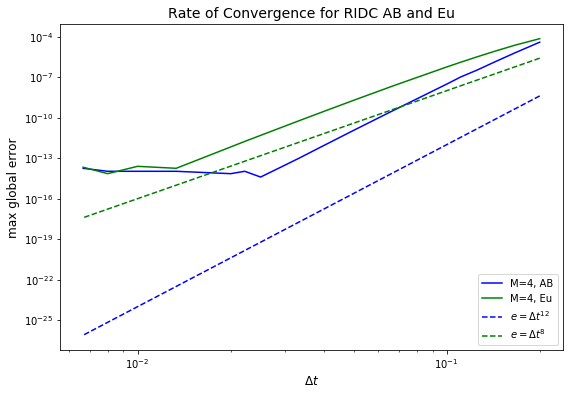

In [211]:
test1 = [i**12 for i in stepsizelist3]
test2 = [i**8 for i in stepsizelist3]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

plt.plot(stepsizelist3, errorlist3, 'b-', markersize=2, label = 'M=4, AB')
plt.plot(stepsizelist2, errorlist2, 'g-', markersize=2, label = 'M=4, Eu')
plt.plot(stepsizelist3, test1,'b--',markersize=2,label = '$e = \Delta t^{12}$ ' )
plt.plot(stepsizelist3, test2, 'g--', markersize=2,label = '$e = \Delta t^{8}$ ' )
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for RIDC AB and Eu',fontsize = 14)

plt.show()

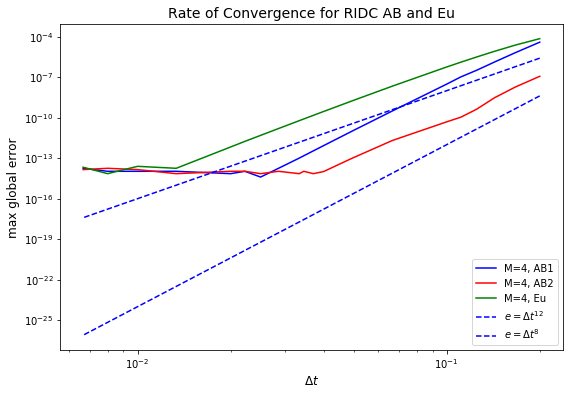

In [239]:
test1 = [i**12 for i in stepsizelist3]
test2 = [i**8 for i in stepsizelist3]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

plt.plot(stepsizelist3, errorlist3, 'b-', markersize=2, label = 'M=4, AB1')
plt.plot(stepsizelist4, errorlist4, 'r-', markersize=2, label = 'M=4, AB2')
plt.plot(stepsizelist2, errorlist2, 'g-', markersize=2, label = 'M=4, Eu')
plt.plot(stepsizelist3, test1,'b--',markersize=2,label = '$e = \Delta t^{12}$ ' )
plt.plot(stepsizelist3, test2,'b--',markersize=2,label = '$e = \Delta t^{8}$ ' )
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for RIDC AB and Eu',fontsize = 14)

plt.show()

In [331]:
def HOSSEINsolverAB2(func, T, y0, N, M):
    '''
    Inputs:
    func: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop
    
    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros(N+1)
    # putting the initial condition in y
    yy[0] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M])
    F1[:, 0] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones(M)*y0
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 8
    
 
    for iTime in range(0, M-1):
        
        k_1 = F1[0, iTime]
        k_2 = func(t[iTime]+h*(4/27),Y2[0]+(h*4/27)*k_1 )
        k_3 = func(t[iTime]+h*(2/9) ,Y2[0]+  (h/18)*(k_1+3*k_2))
        k_4 = func(t[iTime]+h*(1/3) ,Y2[0]+  (h/12)*(k_1+3*k_3))
        k_5 = func(t[iTime]+h*(1/2) ,Y2[0]+   (h/8)*(k_1+3*k_4))
        k_6 = func(t[iTime]+h*(2/3) ,Y2[0]+  (h/54)*(13*k_1-27*k_3+42*k_4+8*k_5))
        k_7 = func(t[iTime]+h*(1/6) ,Y2[0]+(h/4320)*(389*k_1-54*k_3+966*k_4-824*k_5+243*k_6))
        k_8 = func(t[iTime]+h       ,Y2[0]+  (h/20)*(-234*k_1+81*k_3-1164*k_4+656*k_5-122*k_6+800*k_7) )
        k_9 = func(t[iTime]+h*(5/6) ,Y2[0]+ (h/288)*(-127*k_1+18*k_3-678*k_4+456*k_5-9*k_6+576*k_7+4*k_8)  )
        k_10= func(t[iTime]+h       ,Y2[0]+(h/820)*(1481*k_1-81*k_3+7104*k_4-3376*k_5+72*k_6-5040*k_7-60*k_8+720*k_9))
        Y2[0] = Y2[0] + h/840*(41*k_1+27*k_4+272*k_5+27*k_6+216*k_7+216*k_9+41*k_10)
        
        

        F1[0, iTime+1] = func(t[iTime+1], Y2[0])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, iTime]-F1[ll, iTime]) + \
                h * np.dot(S[iTime, :], F1[ll, :])
            F1[iCor, iTime+1] = func(t[iTime+1], Y2[iCor])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1] = Y2[M-1] + h*(F2-F1[M-2, iTime]) + \
            h * np.dot(S[iTime, :], F1[M-2, :])
        F2 = func(t[iTime+1], Y2[M-1])
        yy[iTime+1] = Y2[M-1]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(4)
    beta_vec2 = beta(3)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, -4:])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1            
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
                h * np.dot(Svec, F1[ll, :])
        F1[0, 0: M-1] = F1[0, 1: M]
        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0: M-1] = F1[iCor, 1: M]
            F1[iCor, M-1] = func(t_ext[iTime+1-iCor], Y2[iCor])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, -4:])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            # Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
            #    h * np.dot(Svec, F1[ll, :])
            Fvec = np.array([F1[iCor, -3]-F1[ll, -4], F1[iCor, -2] -
                             F1[ll, -3], F1[iCor, -1]-F1[ll, -2]])
            Y2[iCor] = Y2[iCor] + h*np.dot(beta_vec2, Fvec) + \
                h * np.dot(Svec, F1[ll, :])
        # last correction loop
        F2m = func(t_ext[iTime+1-(M-1)-2], yy[iTime+1-(M-1)-2])
        F2mm = func(t_ext[iTime+1-(M-1)-3], yy[iTime+1-(M-1)-3])
        Fvec = np.array([F2mm-F1[M-2, -4], F2m-F1[M-2, -3], F2-F1[M-2, -2]])
        Y2[M-1] = Y2[M-1] + h*np.dot(beta_vec2, Fvec) + \
            h * np.dot(Svec, F1[M-2, :])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0: M-1] = F1[ll, 1: M]
            F1[ll, M-1] = func(t_ext[iTime+1-ll], Y2[ll])
        # storing the final answer
        yy[iTime+1-(M-1)] = Y2[M-1]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1])
        # ---> updating predictor stencil
        # ** approach #0:
        F1[0, 0: M-1] = F1[0, 1: M]
        # ** approach #1: pushing the most correct answer to predictor
        #F1[0, 0] = F2
        #F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        #F1[0, 0] = F2
        #for ii in range(1, M-1):
            #F1[0, ii] = F1[-ii, -1]

        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])

    return t, yy

HOSSEINsolverAB2(func, 1, np.array([1.0]), 1000, 4)

(array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
 array([1.        , 1.000002  , 1.000008  , ..., 3.98403197, 3.992008  ,
        4.        ]))

In [332]:
errorlist5 = []
stepsizelist5 = []
l=[]

for i in [5,6,7,8,9,10,11,12,13,14,15,20,21,23,25,27,29,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolverAB2(func, 2, np.array([1.0]), i, 4)
    stepsizelist5.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist5.append(max(m))
    l.append((i,max(m)))
l

[(5, 7.714732763730581e-08),
 (6, 1.945617711385239e-08),
 (7, 4.029747202594081e-09),
 (8, 9.365024311591696e-10),
 (9, 1.743964972433787e-10),
 (10, 4.3236525471002096e-11),
 (11, 3.2867486510212984e-11),
 (12, 2.5305535444886118e-11),
 (13, 1.6213697051625786e-11),
 (14, 9.752199048307375e-12),
 (15, 5.734968056003709e-12),
 (20, 4.2787995369053533e-13),
 (21, 2.637889906509372e-13),
 (23, 1.0458300891968975e-13),
 (25, 4.3520742565306136e-14),
 (27, 1.9539925233402755e-14),
 (29, 8.881784197001252e-15),
 (30, 5.995204332975845e-15),
 (35, 7.105427357601002e-15),
 (40, 7.105427357601002e-15),
 (45, 1.4210854715202004e-14),
 (50, 7.105427357601002e-15),
 (75, 1.0658141036401503e-14),
 (100, 1.4210854715202004e-14),
 (125, 1.7763568394002505e-14),
 (150, 1.4210854715202004e-14)]

In [303]:
def HOSSEINsolverAB2feedback(func, T, y0, N, M):
    '''
    Inputs:
    func: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop
    
    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros(N+1)
    # putting the initial condition in y
    yy[0] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M])
    F1[:, 0] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones(M)*y0
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 8
    
 
    for iTime in range(0, M-1):
        
        k_1 = F1[0, iTime]
        k_2 = func(t[iTime]+h*(4/27),Y2[0]+(h*4/27)*k_1 )
        k_3 = func(t[iTime]+h*(2/9) ,Y2[0]+  (h/18)*(k_1+3*k_2))
        k_4 = func(t[iTime]+h*(1/3) ,Y2[0]+  (h/12)*(k_1+3*k_3))
        k_5 = func(t[iTime]+h*(1/2) ,Y2[0]+   (h/8)*(k_1+3*k_4))
        k_6 = func(t[iTime]+h*(2/3) ,Y2[0]+  (h/54)*(13*k_1-27*k_3+42*k_4+8*k_5))
        k_7 = func(t[iTime]+h*(1/6) ,Y2[0]+(h/4320)*(389*k_1-54*k_3+966*k_4-824*k_5+243*k_6))
        k_8 = func(t[iTime]+h       ,Y2[0]+  (h/20)*(-234*k_1+81*k_3-1164*k_4+656*k_5-122*k_6+800*k_7) )
        k_9 = func(t[iTime]+h*(5/6) ,Y2[0]+ (h/288)*(-127*k_1+18*k_3-678*k_4+456*k_5-9*k_6+576*k_7+4*k_8)  )
        k_10= func(t[iTime]+h       ,Y2[0]+(h/820)*(1481*k_1-81*k_3+7104*k_4-3376*k_5+72*k_6-5040*k_7-60*k_8+720*k_9))
        Y2[0] = Y2[0] + h/840*(41*k_1+27*k_4+272*k_5+27*k_6+216*k_7+216*k_9+41*k_10)
        
        

        F1[0, iTime+1] = func(t[iTime+1], Y2[0])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, iTime]-F1[ll, iTime]) + \
                h * np.dot(S[iTime, :], F1[ll, :])
            F1[iCor, iTime+1] = func(t[iTime+1], Y2[iCor])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1] = Y2[M-1] + h*(F2-F1[M-2, iTime]) + \
            h * np.dot(S[iTime, :], F1[M-2, :])
        F2 = func(t[iTime+1], Y2[M-1])
        yy[iTime+1] = Y2[M-1]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(4)
    beta_vec2 = beta(3)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, -4:])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
                h * np.dot(Svec, F1[ll, :])
        F1[0, 0: M-1] = F1[0, 1: M]
        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0: M-1] = F1[iCor, 1: M]
            F1[iCor, M-1] = func(t_ext[iTime+1-iCor], Y2[iCor])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, -4:])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            # Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
            #    h * np.dot(Svec, F1[ll, :])
            Fvec = np.array([F1[iCor, -3]-F1[ll, -4], F1[iCor, -2] -
                             F1[ll, -3], F1[iCor, -1]-F1[ll, -2]])
            Y2[iCor] = Y2[iCor] + h*np.dot(beta_vec2, Fvec) + \
                h * np.dot(Svec, F1[ll, :])
        # last correction loop
        F2m = func(t_ext[iTime+1-(M-1)-2], yy[iTime+1-(M-1)-2])
        F2mm = func(t_ext[iTime+1-(M-1)-3], yy[iTime+1-(M-1)-3])
        Fvec = np.array([F2mm-F1[M-2, -4], F2m-F1[M-2, -3], F2-F1[M-2, -2]])
        Y2[M-1] = Y2[M-1] + h*np.dot(beta_vec2, Fvec) + \
            h * np.dot(Svec, F1[M-2, :])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0: M-1] = F1[ll, 1: M]
            F1[ll, M-1] = func(t_ext[iTime+1-ll], Y2[ll])
        # storing the final answer
        yy[iTime+1-(M-1)] = Y2[M-1]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1])
        # ---> updating predictor stencil
        # ** approach #0:
        #F1[0, 0: M-1] = F1[0, 1: M]
        # ** approach #1: pushing the most correct answer to predictor
        F1[0, 0] = F2
        F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        #F1[0, 0] = F2
        #for ii in range(1, M-1):
            #F1[0, ii] = F1[-ii, -1]

        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])

    return t, yy


In [304]:
errorlist6 = []
stepsizelist6 = []
l=[]

for i in [5,6,7,8,9,10,11,12,13,14,15,20,21,23,25,27,29,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolverAB2feedback(func, 2, np.array([1.0]), i, 4)
    stepsizelist6.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist6.append(max(m))
    l.append((i,max(m)))
l1,l

([(5, 1.1582201331350461e-07),
  (6, 1.854367326359352e-08),
  (7, 3.0024365216263504e-09),
  (8, 4.243347895283023e-10),
  (9, 1.0830536467665297e-10),
  (10, 8.922995675675338e-11),
  (11, 5.519051882174608e-11),
  (12, 3.163780348813816e-11),
  (13, 1.787547887488472e-11),
  (14, 1.014655026665423e-11),
  (15, 5.824674076393421e-12),
  (20, 4.511946372076636e-13),
  (21, 2.8821389719269064e-13),
  (23, 1.2301271112846734e-13),
  (25, 5.417888360170764e-14),
  (27, 2.5757174171303632e-14),
  (29, 1.199040866595169e-14),
  (30, 8.881784197001252e-15),
  (35, 3.552713678800501e-15),
  (40, 1.7763568394002505e-14),
  (45, 1.0658141036401503e-14),
  (50, 7.105427357601002e-15),
  (75, 1.0658141036401503e-14),
  (100, 1.0658141036401503e-14),
  (125, 1.7763568394002505e-14),
  (150, 1.4210854715202004e-14)],
 [(5, 1.1582201331350461e-07),
  (6, 1.854367326359352e-08),
  (7, 3.0024365216263504e-09),
  (8, 4.243347895283023e-10),
  (9, 1.0830536467665297e-10),
  (10, 7.968914417233464e-11),

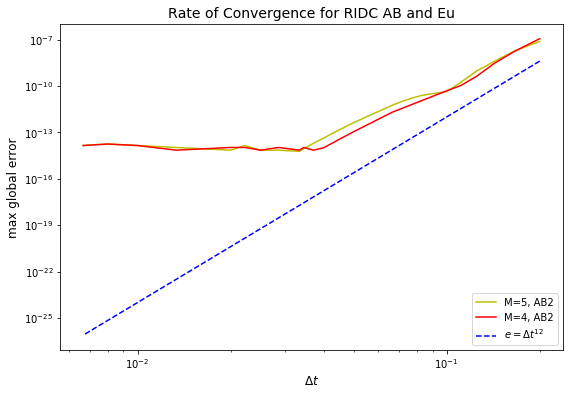

In [333]:
test1 = [i**12 for i in stepsizelist5]
test2 = [i**8 for i in stepsizelist3]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

plt.plot(stepsizelist5, errorlist5, 'y-', markersize=2, label = 'M=5, AB2')
#plt.plot(stepsizelist3, errorlist3, 'b-', markersize=2, label = 'M=4, AB')
plt.plot(stepsizelist4, errorlist4, 'r-', markersize=2, label = 'M=4, AB2')
#plt.plot(stepsizelist2, errorlist2, 'g-', markersize=2, label = 'M=4, Eu')
#plt.plot(stepsizelist6, errorlist6, 'p-', markersize=2, label = 'M=4, AB2feedback')
plt.plot(stepsizelist5, test1,'b--',markersize=2,label = '$e = \Delta t^{12}$ ' )

ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for RIDC AB and Eu',fontsize = 14)

plt.show()